In [6]:
#"Hayvan Tanıma Git Repostory Oluşturuldu"

In [7]:
import os

import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, History
import tensorflow as tf
from time import time
import numpy as np
import pandas as pd

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"  # UYARILARI KAPATMA


In [8]:
#print(os.listdir("./images/train"))
SIZE = 224
EPOCH = 5
BATCH = 32
train_directory = "images/train/"
valid_directory = "images/valid/"
test_directory = "images/test/"

data_aug = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
    preprocessing_function=preprocess_input
)
#Max batch size= available GPU memory bytes / 4 / (size of tensors + trainable parameters)
train_generator = data_aug.flow_from_directory(directory=train_directory,
                                               batch_size=BATCH,
                                               shuffle=True,
                                               class_mode="categorical",
                                               color_mode="rgb",
                                               target_size=(SIZE, SIZE),
                                               interpolation="nearest",
                                               seed=42
                                               )
validation_generator = data_aug.flow_from_directory(directory=valid_directory,
                                                    batch_size=BATCH,
                                                    shuffle=True,
                                                    class_mode="categorical",
                                                    color_mode="rgb",
                                                    target_size=(SIZE, SIZE),
                                                    interpolation="nearest",
                                                    seed=42
                                                    )
test_generator = data_aug.flow_from_directory(directory=test_directory,
                                              batch_size=1,
                                              shuffle=False,
                                              class_mode="categorical",
                                              color_mode="rgb",
                                              target_size=(SIZE, SIZE),
                                              seed=42
                                              )




Found 5836 images belonging to 37 classes.
Found 777 images belonging to 37 classes.
Found 777 images belonging to 37 classes.


In [9]:
print(train_generator.class_indices)

{'Abyssinian': 0, 'Bengal': 1, 'Birman': 2, 'Bombay': 3, 'British_Shorthair': 4, 'Egyptian_Mau': 5, 'Maine_Coon': 6, 'Persian': 7, 'Ragdoll': 8, 'Russian_Blue': 9, 'Siamese': 10, 'Sphynx': 11, 'american_bulldog': 12, 'american_pit_bull_terrier': 13, 'basset_hound': 14, 'beagle': 15, 'boxer': 16, 'chihuahua': 17, 'english_cocker_spaniel': 18, 'english_setter': 19, 'german_shorthaired': 20, 'great_pyrenees': 21, 'havanese': 22, 'japanese_chin': 23, 'keeshond': 24, 'leonberger': 25, 'miniature_pinscher': 26, 'newfoundland': 27, 'pomeranian': 28, 'pug': 29, 'saint_bernard': 30, 'samoyed': 31, 'scottish_terrier': 32, 'shiba_inu': 33, 'staffordshire_bull_terrier': 34, 'wheaten_terrier': 35, 'yorkshire_terrier': 36}


In [10]:
tf.keras.backend.clear_session()

In [11]:

vgg16_model = VGG16(pooling="avg", input_shape=(224, 224, 3), weights="imagenet", include_top=False)
vgg16_model.layers[0].trainable=False

VGG = tf.keras.Sequential([
    vgg16_model,
    Flatten(),
    Dense(units=512, activation="relu"),
    Dropout(0.1),
    Dense(units=256, activation="relu"),
    Dropout(0.1),
    Dense(units=37, activation="softmax")
])

VGG.compile(loss="categorical_crossentropy", optimizer="adam",
            metrics=["acc"])



In [12]:
vgg16_filepath = 'vgg_16_' + '-saved-model-{epoch:02d}-acc-{val_acc:.2f}.hdf5'
vgg16_checkpoint = ModelCheckpoint(filepath=vgg16_filepath,
                                   save_best_only=True,
                                   monitor="val_acc",
                                   mode="max",
                                   verbose=1
                                   )
vgg16_early_stopping = EarlyStopping(monitor="val_loss",
                                     restore_best_weights=True,
                                     patience=5,
                                     verbose=1,
                                     )
vgg16_tensorboard = TensorBoard(log_dir="logs/{}".format(time()),
                                write_graph=True,
                                write_images=True,
                                histogram_freq=0)
vgg16_history_callback = History()

Step_size_train =len(train_generator)
Step_size_valid = len(validation_generator)
Step_size_test = len(test_generator)
print(Step_size_train, Step_size_valid)
vgg_history = VGG.fit_generator(
    generator=train_generator,
    validation_data=validation_generator,
    epochs=EPOCH,
    callbacks=[vgg16_history_callback, vgg16_checkpoint, vgg16_early_stopping, vgg16_tensorboard],
    steps_per_epoch=Step_size_train,
    validation_steps=Step_size_valid
)


183 25
Epoch 1/5
  2/183 [..............................] - ETA: 27:06 - loss: 7.2302 - acc: 0.0156

2022-05-01 13:30:10.690641: E tensorflow/core/platform/default/device_tracer.cc:68] CUPTI error: CUPTI_ERROR_INVALID_PARAMETER


182/183 [============================>.] - ETA: 1s - loss: 3.6656 - acc: 0.0284
Epoch 00001: val_acc improved from -inf to 0.02574, saving model to vgg_16_-saved-model-01-acc-0.03.hdf5
183/183 [==============================] - 340s 2s/step - loss: 3.6654 - acc: 0.0283 - val_loss: 3.6099 - val_acc: 0.0257
Epoch 2/5
182/183 [============================>.] - ETA: 1s - loss: 3.6128 - acc: 0.0227
Epoch 00002: val_acc improved from 0.02574 to 0.02703, saving model to vgg_16_-saved-model-02-acc-0.03.hdf5
183/183 [==============================] - 319s 2s/step - loss: 3.6128 - acc: 0.0230 - val_loss: 3.6109 - val_acc: 0.0270
Epoch 3/5
182/183 [============================>.] - ETA: 1s - loss: 3.6118 - acc: 0.0210
Epoch 00003: val_acc did not improve from 0.02703
183/183 [==============================] - 296s 2s/step - loss: 3.6118 - acc: 0.0211 - val_loss: 3.6111 - val_acc: 0.0270
Epoch 4/5
182/183 [============================>.] - ETA: 1s - loss: 3.6116 - acc: 0.0195
Epoch 00004: val_acc 

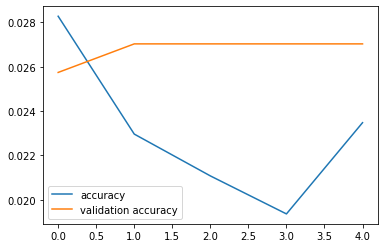

In [13]:
plt.plot(vgg16_history_callback.history["acc"])
plt.plot(vgg16_history_callback.history['val_acc'])
plt.legend(['accuracy', 'validation accuracy'])

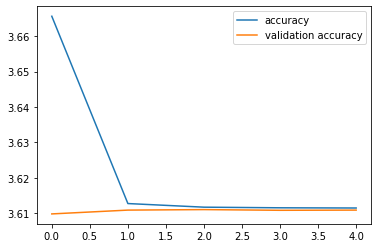

In [14]:
plt.plot(vgg16_history_callback.history["loss"])
plt.plot(vgg16_history_callback.history['val_loss'])
plt.legend(['accuracy', 'validation accuracy'])

In [15]:
VGG.evaluate_generator(generator=validation_generator,
                       steps=Step_size_valid)
test_generator.reset()

pred = VGG.predict_generator(generator=test_generator,
                             steps=Step_size_test,
                             verbose=1)
predicted_class_indces = np.argmax(pred, axis=1)

777/777 [==============================] - 29s 38ms/step


In [16]:
labels = train_generator.class_indices
labels = dict((v, k) for k, v in labels.items())
predictions = [labels[k] for k in predicted_class_indces]

In [17]:
filenames = test_generator.filenames
results = pd.DataFrame({"Filename": filenames,
                        "Predictions": predictions})
results.to_csv("results.csv", index=False)

In [18]:
results

,Filename,Predictions
0,Abyssinian/Abyssinian_1.jpg,saint_bernard
1,Abyssinian/Abyssinian_10.jpg,saint_bernard
2,Abyssinian/Abyssinian_11.jpg,saint_bernard
3,Abyssinian/Abyssinian_12.jpg,saint_bernard
4,Abyssinian/Abyssinian_13.jpg,saint_bernard
...,...,...
772,yorkshire_terrier/yorkshire_terrier_4.jpg,saint_bernard
773,yorkshire_terrier/yorkshire_terrier_5.jpg,saint_bernard
774,yorkshire_terrier/yorkshire_terrier_6.jpg,saint_bernard
775,yorkshire_terrier/yorkshire_terrier_7.jpg,saint_bernard
